# Ellipse Cloud: Anisotropy-aware persistent homology analysis

In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import ellphi

In [2]:
%matplotlib inline

In [3]:
rng = numpy.random.default_rng(seed=7777) # 20250224
# rng = numpy.random.default_rng(seed=777)
# rng = numpy.random.default_rng(seed=77)

radius = 0.6 # 基本ノイズ円の半径
alpha = 0.4 # 基本円のアスペクト比
num_points = 100 # 基本円の点数
near = 25
eps = 0.19 # ノイズ一様分布 [-eps, eps]
shape_clusters = (2, 3) # 基本円をこの列・行ならべる
max_iter = 3000
pd_hist_config = dict(colorbar=dict(type="log", colormap='viridis'))

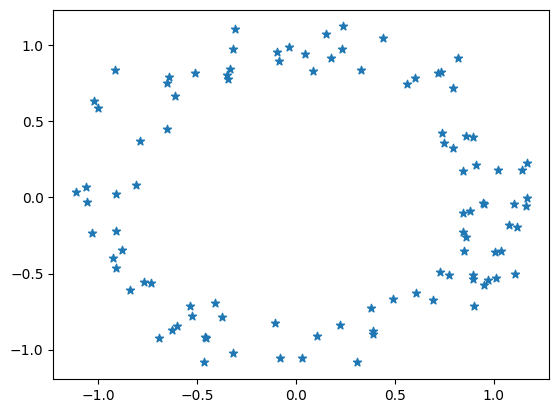

In [4]:
theta = rng.uniform(0, 2 * numpy.pi, num_points)
noise = rng.uniform(-eps, eps, size=(num_points, 2))
x, y = (ellphi.unit_vector(theta) + noise).T
plt.scatter(x, y, marker='*')

In [5]:
theta = rng.uniform(0, 2 * numpy.pi, num_points)
x_circle, y_circle = ellphi.unit_vector(theta).T
x_circle *= radius
y_circle *= radius * alpha # shrink

x = numpy.zeros((*shape_clusters, num_points))
y = numpy.zeros((*shape_clusters, num_points))
for i in range(shape_clusters[0]):
    for j in range(shape_clusters[1]):
        x_noise = rng.uniform(-eps, eps, size=num_points)
        y_noise = rng.uniform(-eps, eps, size=num_points)
        x[i, j] = x_circle + x_noise + j
        y[i, j] = y_circle + y_noise + i * alpha

# build a point cloud (num_points, 2)
x, y = x.ravel(), y.ravel()
data = numpy.stack([x, y], axis=1)
data.shape

(600, 2)

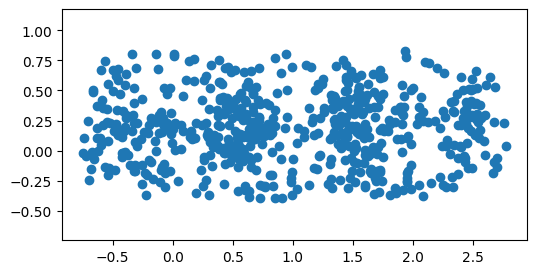

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(x, y, marker='o')
ax.set_aspect('equal', adjustable='datalim')
plt.show()

In [7]:
ellcloud = ellphi.ellipse_cloud(data, k=near)
print(ellcloud)

EllipseCloud(coef=array<(564, 6)>, mean=array<(564, 2)>, cov=array<(564, 2, 2)>, k=25, nbd=array<(564, 25)>)


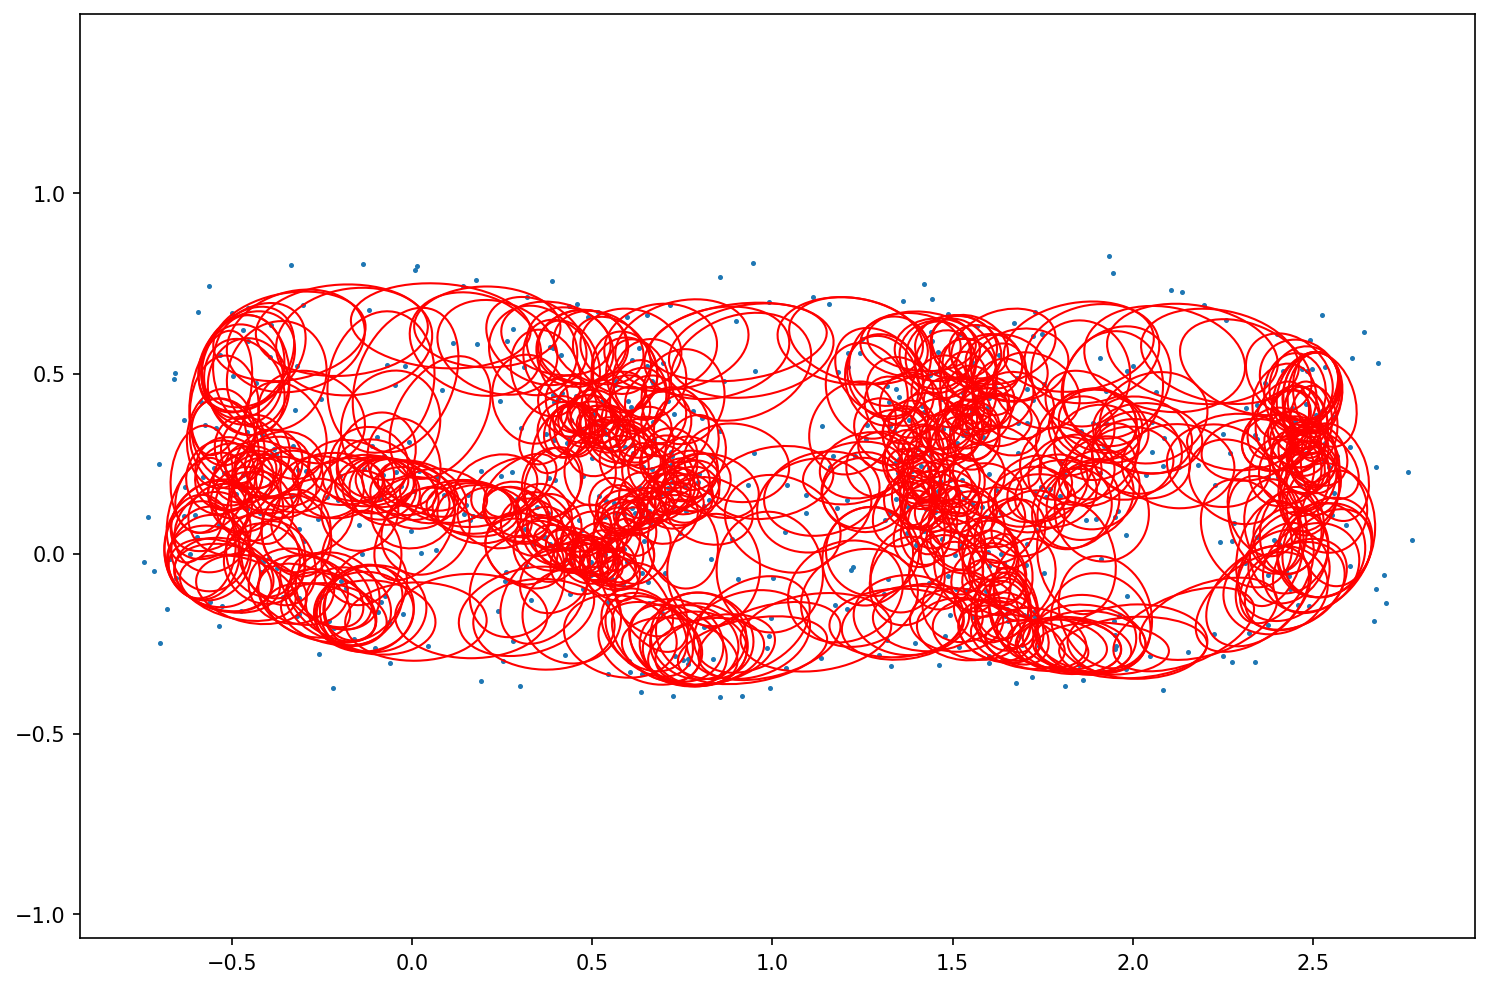

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=150)
ax.scatter(x, y, s=2, marker='o')
ax.set_aspect('equal', adjustable='datalim')
ellcloud.plot(ax=ax, edgecolor='red')
plt.show()

## スケールパラメタ $r$ によるフィルトレーションのパーシステントホモロジー

In [9]:
dist = squareform(ellcloud.pdist_tangency())
dist.shape

(564, 564)

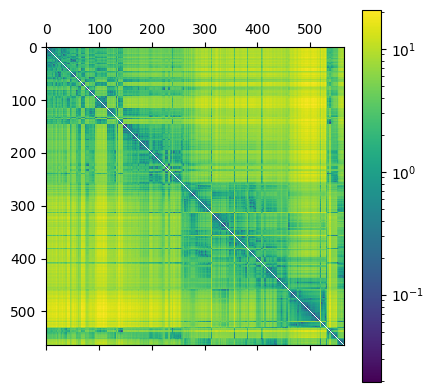

In [10]:
plt.matshow(dist, norm='log')
plt.colorbar()

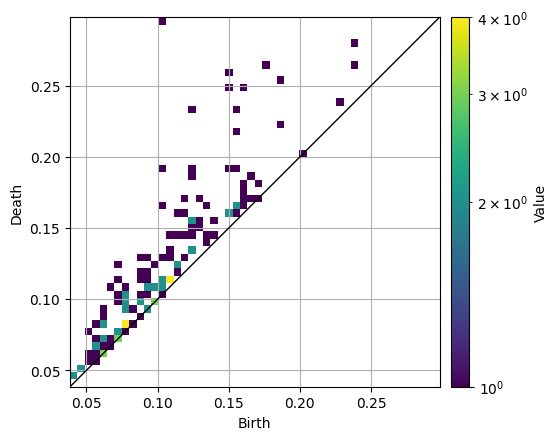

In [11]:
import homcloud.interface as hc

dist_orig = squareform(pdist(data))
hc.PDList.from_rips_filtration(dist_orig, maxdim=1, save_to="rips.pdgm", save_graph=True)
pdlist = hc.PDList("rips.pdgm")
pd1 = pdlist.dth_diagram(1)
pd1.histogram(x_bins=50).plot(**pd_hist_config)
plt.show()

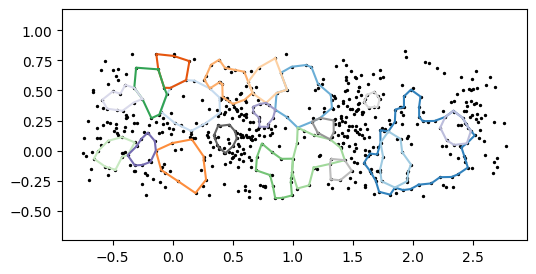

In [12]:
cmap = matplotlib.colormaps['tab20c']

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(x, y, s=2, marker='o', color='black')
ax.set_aspect('equal', adjustable='datalim')

take = 20
sorted_pairs = sorted(
    pd1.pairs(), reverse=True,
    key=lambda p: p.death_time() - p.birth_time())
for bd, color in zip(sorted_pairs[:take], cmap(numpy.arange(take))):
    opt1_cycle = bd.optimal_1_cycle()
    opt1_cycle_indices = opt1_cycle.boundary_points()
    line_indices = [*opt1_cycle_indices, opt1_cycle_indices[0]]
    ax.plot(x[line_indices], y[line_indices], c=color)

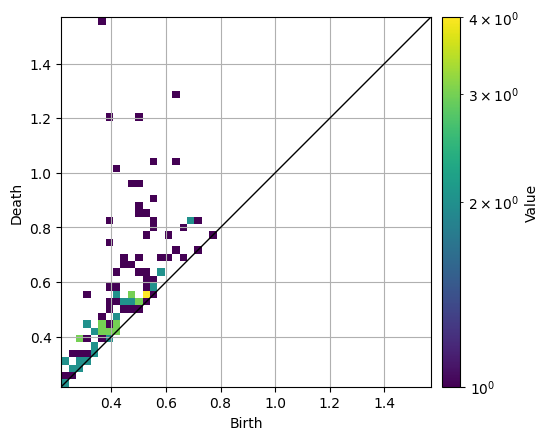

In [13]:
hc.PDList.from_rips_filtration(dist, maxdim=1, save_to="rips.pdgm", save_graph=True)
pdlist = hc.PDList("rips.pdgm")
pd1 = pdlist.dth_diagram(1)
pd1.histogram(x_bins=50).plot(**pd_hist_config)
plt.show()

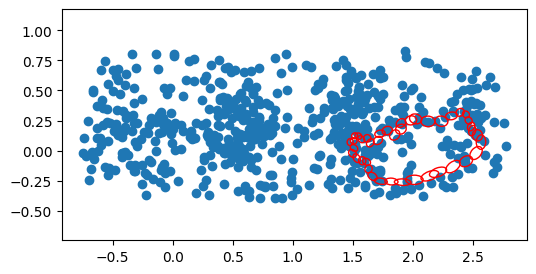

In [14]:
# https://homcloud.dev/python-api/interface.html#homcloud.interface.Pair.optimal_1_cycle
bd = max(pd1.pairs(), key=lambda p: p.death_time())
optimal_1_cycle = bd.optimal_1_cycle()
birth = bd.birth_time()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(x, y, marker='o')
ax.set_aspect('equal', adjustable='datalim')
ellcloud.plot(
    ids=optimal_1_cycle.boundary_points(),
    ax=ax, edgecolor='red',
    scale=birth
)
plt.show()

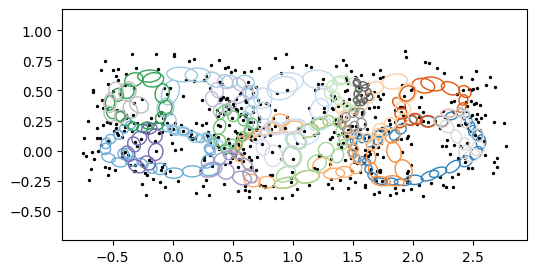

In [15]:
cmap = matplotlib.colormaps['tab20c']

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(x, y, s=2, marker='o', color='black')
ax.set_aspect('equal', adjustable='datalim')

take = 20
sorted_pairs = sorted(
    pd1.pairs(), reverse=True,
    key=lambda p: p.death_time() - p.birth_time())

for bd, color in zip(sorted_pairs[:take], cmap(numpy.arange(take))):
    opt1_cycle = bd.optimal_1_cycle()
    birth = bd.birth_time()
    ellcloud.plot(
        ids=opt1_cycle.boundary_points(),
        ax=ax, edgecolor=color,
        scale=birth
    )
plt.show()